## Plotting data in real time

In [5]:
import os
import glob
import time
import re
import datetime
import numpy as np
from matplotlib import cm
import matplotlib.axes as maxes
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Circle
import matplotlib.animation as animation

from lofarimaging import read_acm_cube, get_station_type, make_xst_plots, freq_from_sb

In [6]:
def setup_sky_plot(**kwargs):
    """Set up a sky plot figure (only once). Returns (fig, ax, im) handles."""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    
    # Draw the unit circle
    circle1 = Circle((0, 0), 1.0, edgecolor='k', fill=False, alpha=0.3)
    ax.add_artist(circle1)
    
    data = np.zeros((150, 150))
    cimg = ax.imshow(data, origin='lower', cmap=cm.Spectral_r, extent=(1, -1, -1, 1),
                     clip_path=circle1, clip_on=True, **kwargs)
    
    # Create colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2, axes_class=maxes.Axes)
    fig.colorbar(cimg, cax=cax, orientation="vertical", format="%.2e")
    
    # Set labels, ticks, etc.
    ax.set_xlim(1, -1)
    ax.set_xticks(np.arange(-1, 1.1, 0.5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_yticks(np.arange(-1, 1.1, 0.5))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    ax.set_xlabel('$\\ell$', fontsize=14)
    ax.set_ylabel('$m$', fontsize=14)
    
    # Compass directions
    ax.text(0.9, 0, 'E', ha='center', va='center', color='w', fontsize=17)
    ax.text(-0.9, 0, 'W', ha='center', va='center', color='w', fontsize=17)
    ax.text(0, 0.9, 'N', ha='center', va='center', color='w', fontsize=17)
    ax.text(0, -0.9, 'S', ha='center', va='center', color='w', fontsize=17)
    
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return fig, ax, cimg

In [7]:
def get_latest_file(directory, retries=1, delay=1):
    """Returns the latest .dat and .h files in the directory."""
    for _ in range(retries):
        dat_files = sorted(glob.glob(os.path.join(directory, "*.dat")), key=os.path.getmtime)
        h_files = sorted(glob.glob(os.path.join(directory, "*.h")), key=os.path.getmtime)
        if dat_files and h_files:
            return dat_files[-1], h_files[-1]
        time.sleep(delay)
    return None, None

def get_data_obstime(dat_path, station_name):
    station_type = get_station_type(station_name)
    obsdatestr, obstimestr, *_ = os.path.basename(dat_path).rstrip(".dat").split("_")
    obstime = datetime.datetime.strptime(obsdatestr + ":" + obstimestr, '%Y%m%d:%H%M%S')
    visibilities = read_acm_cube(dat_path, station_type)[0]
    return visibilities, obstime

def get_subband(h_filename):
    if os.path.exists(h_filename):
        with open(h_filename, 'r') as file:
            content = file.read()
        
        match = re.search(r'--xcsubband=(\d+)', content)
        if match:
            subband = int(match.group(1))
        else:
            print(f"the hfile wasn't found {h_filename}")
            subband = None 
    else:
        print(f"the hfile wasn't found {h_filename}")
        subband = None

    return subband

In [ ]:
def get_sky_data(frame):
    """
    Called each animation frame. This function:
      1. Checks for the latest .dat file.
      2. Reads and processes the data.
      3. Calls your imaging function (make_xst_plots) to generate a sky image.
      4. Extracts the image array from the generated figure.
      5. Returns the new image data, a subtitle string, and any markers info.
    """
    latest_dat_file, latest_h_file = get_latest_file("./data")
    if not latest_dat_file or not latest_h_file:
        print("No new data files found.")
        return None, None, None
    print(latest_dat_file, latest_h_file)
    station_name = "LV614"
    obstime = datetime.datetime.now()
    subband = get_subband(latest_h_file)
    rcu_mode = 3

    xst_data, obstime = get_data_obstime(latest_dat_file, station_name)


    sky_fig = make_xst_plots(xst_data, station_name, obstime, subband, rcu_mode,
        caltable_dir="./test/CalTables", hdf5_filename=None, sky_only=True)
    
    # Extract the image array from the figure.
    ax_temp = sky_fig.get_axes()[0]
    new_data = ax_temp.get_images()[0].get_array()

    subtitle = f"SB {subband}, {str(obstime)[:16]}\n"
    
    marked_bodies_lmn = {}
    
    os.remove(latest_dat_file)
    os.remove(latest_h_file)
    return new_data, subtitle, marked_bodies_lmn

In [ ]:
def update_sky_plot(frame, im, ax, get_sky_data):
    """
    - `frame`: the current frame index (FuncAnimation passes this automatically).
    - `im`: the imshow object we want to update.
    - `ax`: the axes where we might update text.
    - `get_sky_data`: a function (or callable) that returns a new 2D array 
                      + any relevant annotation data for each frame.
    """

    new_data, subtitle, marked_bodies_lmn = get_sky_data(frame)
    if new_data is None:
        plt.close()
        return []

    im.set_data(new_data)

    im.set_clim(vmin=new_data.min(), vmax=new_data.max())
    
    # 3. Update title or subtitles
    ax.set_title(subtitle)

    return [im]


./data\20230111_094716_xst.dat ./data\20230111_094716_xst.h
./data\20230111_093334_xst.dat ./data\20230111_093334_xst.h
./data\20230111_091952_xst.dat ./data\20230111_091952_xst.h
./data\20230111_090610_xst.dat ./data\20230111_090610_xst.h
./data\20230111_085228_xst.dat ./data\20230111_085228_xst.h
./data\20230111_083846_xst.dat ./data\20230111_083846_xst.h


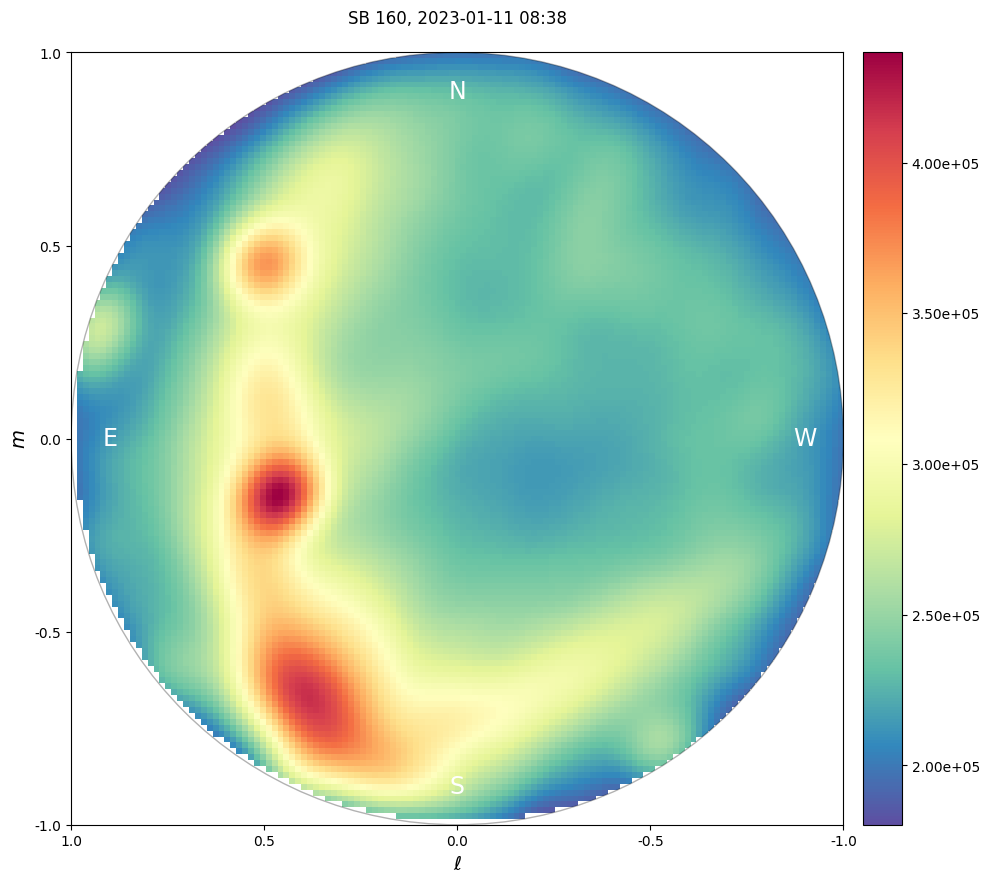

In [12]:

fig, ax, im = setup_sky_plot()

ani = animation.FuncAnimation(
    fig,
    update_sky_plot,
    fargs=(im, ax, get_sky_data),  
    frames=5,
    interval=1000, ##milliseonds
    blit=False        
)

ani.save('my_animation.mp4', fps=1, extra_args=['-vcodec', 'libx264'])
# ani.save(r"animation.gif", fps=10)
plt.show()
